# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. LangGraph is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain it's benefits, and show how it works with LangChain and LangSmith.

![ecosystem](img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat model interface that takes a list of messages as input and returns a message as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1", temperature=0)

## Running the model

The `init_chat_model` interface also provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for running LLMs, which include:
- `invoke()`: Synchronously process inputs and return outputs
- `stream()`: Return outputs [incrementally](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they're generated

In [3]:
result = llm.invoke("What is LangGraph?")

In [4]:
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='**LangGraph** is an open-source framework designed for building stateful, multi-agent applications powered by Large Language Models (LLMs). It extends the popular [LangChain](https://www.langchain.com/) ecosystem, focusing on enabling complex workflows where multiple agents (LLMs, tools, or humans) interact in a graph-like structure.\n\n### Key Features\n\n- **Graph-based Workflows:**  \n  LangGraph lets you define workflows as graphs, where each node can be an agent, a tool, or a function, and edges represent possible transitions based on state or output.\n- **Stateful Interactions:**  \n  Unlike simple chains, LangGraph maintains and updates a shared state as the workflow progresses, allowing for memory, context, and iterative reasoning.\n- **Multi-Agent Collaboration:**  \n  Easily orchestrate multiple agents that can communicate, collaborate, or debate to solve complex tasks.\n- **Flexible Control Flow:**  \n  Supports loops, branching, and conditional logic, mak

In [6]:
result.content

'**LangGraph** is an open-source framework designed for building stateful, multi-agent applications powered by Large Language Models (LLMs). It extends the popular [LangChain](https://www.langchain.com/) ecosystem, focusing on enabling complex workflows where multiple agents (LLMs, tools, or humans) interact in a graph-like structure.\n\n### Key Features\n\n- **Graph-based Workflows:**  \n  LangGraph lets you define workflows as graphs, where each node can be an agent, a tool, or a function, and edges represent possible transitions based on state or output.\n- **Stateful Interactions:**  \n  Unlike simple chains, LangGraph maintains and updates a shared state as the workflow progresses, allowing for memory, context, and iterative reasoning.\n- **Multi-Agent Collaboration:**  \n  Easily orchestrate multiple agents that can communicate, collaborate, or debate to solve complex tasks.\n- **Flexible Control Flow:**  \n  Supports loops, branching, and conditional logic, making it suitable fo

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a model, and whose outputs are designed to be fed back to a model. In LangChain, creating tools is simple using the `@tool` decorator, which transforms Python functions into callable tools. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [9]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

## Tool Calling

[Tool calling](https://python.langchain.com/docs/concepts/tool_calling/) is how models call tools to accomplish tasks. In simple terms, the model returns a schema that is required to call the tool. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

In [10]:
# Connect tools to a chat model
model = init_chat_model("openai:gpt-4.1", temperature=0.0)
model_with_tools = model.bind_tools([write_email], tool_choice="required")

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss about tomorrow's meeting")

In [11]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'to': 'boss@example.com',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Hi [Boss's Name],\n\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow's meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]"}

In [12]:
# Call the tool
result = write_email.invoke(args)
print(result)  # "Email to boss@company.com drafted with subject 'Re: Meeting Tomorrow'"

Email sent to boss@example.com with subject 'Re: Tomorrow's Meeting' and content: Hi [Boss's Name],

I hope this message finds you well. I am writing to confirm my attendance at tomorrow's meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.

Looking forward to our discussion.

Best regards,

[Your Name]


## Agents

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) are systems where language models (LLMs) dynamically direct their own processes and tool usage. 

They are typically implemented as tool calling in a loop - the model decides which tool to use, calls it, and then uses the result to inform the next action. 

This is ideal for open-ended problems where it's difficult to predict the *exact* steps needed in advance.

![agent-img](img/agent_loop.png)

## Workflows

When building LLM applications, agents are just one pattern to consider. 

Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. It does not abstract prompts or architecture, and provides a few central benefits:

- **Execution Control**:  Make it easy to define and combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables memory and human-in-the-loop.
- **Deployment and Debugging**: Provide an easy onramp for testing, debugging, and deploying applications.

### Execution Control

LangGraph is an orchestration framework with [both declarative and imperative APIs](https://blog.langchain.dev/how-to-think-about-agent-frameworks/?utm_source=substack&utm_medium=email).

**Declarative Programming** in LangGraph means:
- Defining the overall structure of your application as a graph
- Specifying what should happen rather than how it happens
- Describing relationships between components through edges and conditions
- Focusing on the "what" by describing the desired state and transitions

Graphs in LangGraph use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to define the overall structure of the application. In addition, LangGraph allows you to define a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that defines a schema for any information you want to track over the course of the application. This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object. 

In [23]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

**Imperative Programming** in LangGraph means:
- The actual implementation of each node's functionality
- Writing code that defines exactly how each process works step-by-step
- Having full control over the logic inside each node
- Focusing on the "how" with detailed instructions

![nodes_edges](img/nodes_edges.png)

In [24]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

This dual approach gives LangGraph its flexibility - you declaratively define the overall structure while maintaining imperative control within each component, providing both high-level orchestration and fine-grained control.

In [25]:
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()
app.invoke({"request": "Draft a response to my boss about tomorrow's meeting"})

{'request': "Draft a response to my boss about tomorrow's meeting",
 'email': "Email sent to boss@example.com with subject 'Re: Tomorrow's Meeting' and content: Hi [Boss's Name],\n\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow's meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\n\nLooking forward to our discussion.\n\nBest regards,\n\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the routing_function's output to the name of the next node.

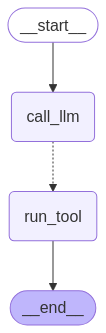

In [30]:
from typing import Literal
from langgraph.graph import MessagesState

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", END]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]})
result["messages"]

[HumanMessage(content="Draft a response to my boss about tomorrow's meeting", additional_kwargs={}, response_metadata={}, id='5e2d9fe3-c075-47ba-a253-f06ffb67aab5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iIS382COCMtqYtfwIfBBf8P9', 'function': {'arguments': '{"to":"boss@example.com","subject":"Re: Tomorrow\'s Meeting","content":"Hi [Boss\'s Name],\\n\\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow\'s meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\\n\\nLooking forward to our discussion.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 61, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': 

### Persistence

It can be very useful to the pause the graph during execution. As we'll see later, this enables interaction like human-in-the-loop. LangGraph has a built-in persistence layer, implemented through checkpointers. When you compile graph with a checkpointer, the checkpointer saves a [checkpoints](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every super-step. Those checkpoints are saved to a thread, which can be accessed after graph execution. Using checkpoints is simple - you only need to specify a `thread_id` when invoking a graph, and LangGraph handles the persistence automatically.


In [33]:
from langgraph.checkpoint.memory import InMemorySaver
app = workflow.compile(checkpointer=InMemorySaver())

config = {"configurable": {"thread_id": "1"}}
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss about tomorrow's meeting"}]}, config)
                    

In [34]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
app.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="Draft a response to my boss about tomorrow's meeting", additional_kwargs={}, response_metadata={}, id='8545648c-aaf3-4973-a9c1-9eebb67a5373'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JiUJeMikwtibD6AeDVtFas0p', 'function': {'arguments': '{"to":"boss@example.com","subject":"Re: Tomorrow\'s Meeting","content":"Hi [Boss\'s Name],\\n\\nI hope this message finds you well. I am writing to confirm my attendance at tomorrow\'s meeting. Please let me know if there are any specific topics or materials you would like me to prepare in advance.\\n\\nLooking forward to our discussion.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 61, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_token

### Deployment and Debugging

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

In [ ]:
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_API_KEY")

Trace from above graph execution:

https://smith.langchain.com/public/6e5d8983-e88c-490b-a087-91a94765d7c2/r

When you've built a graph, it's easy to deploy using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). A deployment hosts with the graph with an API [server](https://langchain-ai.github.io/langgraph/concepts/langgraph_server/) and offers an interactive IDE (LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)).

We can start a deployment locally using `langgraph dev`:

In [ ]:
! langgraph dev

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)